# Multi-view Neural Network model based on ResNet50 for multi-label image classification

#### Base info: 9 signal datasets, containing sequences collected from various sensors. Each signal was transformed using continous wavelet transform (from pywavelet module) and such scaleograms are passed as input images into NN-model. The goal is to predict one of the 7 labels representing different human activity.
#### Dataset Source: https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk")
plt.style.use('ggplot')

In [4]:
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, Concatenate, Flatten
from tensorflow.keras import Input, Model
from tensorflow import keras

In [18]:
from sklearn.metrics import classification_report, confusion_matrix

### Load data

In [5]:
y_train = np.loadtxt("UCI HAR Dataset/train/y_train.txt")
y_test = np.loadtxt("UCI HAR Dataset/test/y_test.txt")

In [6]:
y_train = to_categorical(y_train).astype(np.int8)
y_test = to_categorical(y_test).astype(np.int8)

In [7]:
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

y_train shape:  (7352, 7)
y_test shape:  (2947, 7)


In [8]:
X_train = np.load("train_signals.npy")
X_test = np.load("test_signals.npy")

In [9]:
print("x_train shape: ", X_train.shape)
print("x_test shape: ", X_test.shape)

x_train shape:  (9, 7352, 128, 128, 3)
x_test shape:  (9, 2947, 128, 128, 3)


In [10]:
single_input_shape = (128,128,3)
epochs=10
batch_size=1
num_features = 9
num_classes = 7

### Build multi-view model with ResNet50 as base

In [11]:
def build_multiview_model(base_model, num_features, input_shape, num_classes):
    """
    Creates multi-view neural network Keras model for multi-label classification
    based on `base_model` and number of features.
    - base_model - Keras model object
    - num_features - integer - number of features in dataset (different types of images)
    - num_classes - integer - number of classes to predict
    """
    inputs = []
    partial_outputs = []

    for i in range(num_features):
        inputs.append(Input(shape=input_shape))

    for input_layer in inputs:
        part_output = base_model(input_layer)
        fpart_output = Flatten()(part_output)
        partial_outputs.append(fpart_output)

    x = keras.layers.concatenate(partial_outputs)
    output = Dense(num_classes, activation="softmax", name="output")(x)

    model = Model(
        inputs=inputs,
        outputs=output,
    )
    return model

In [12]:

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=single_input_shape)

In [13]:
model = build_multiview_model(base_model, num_features, single_input_shape, num_classes)

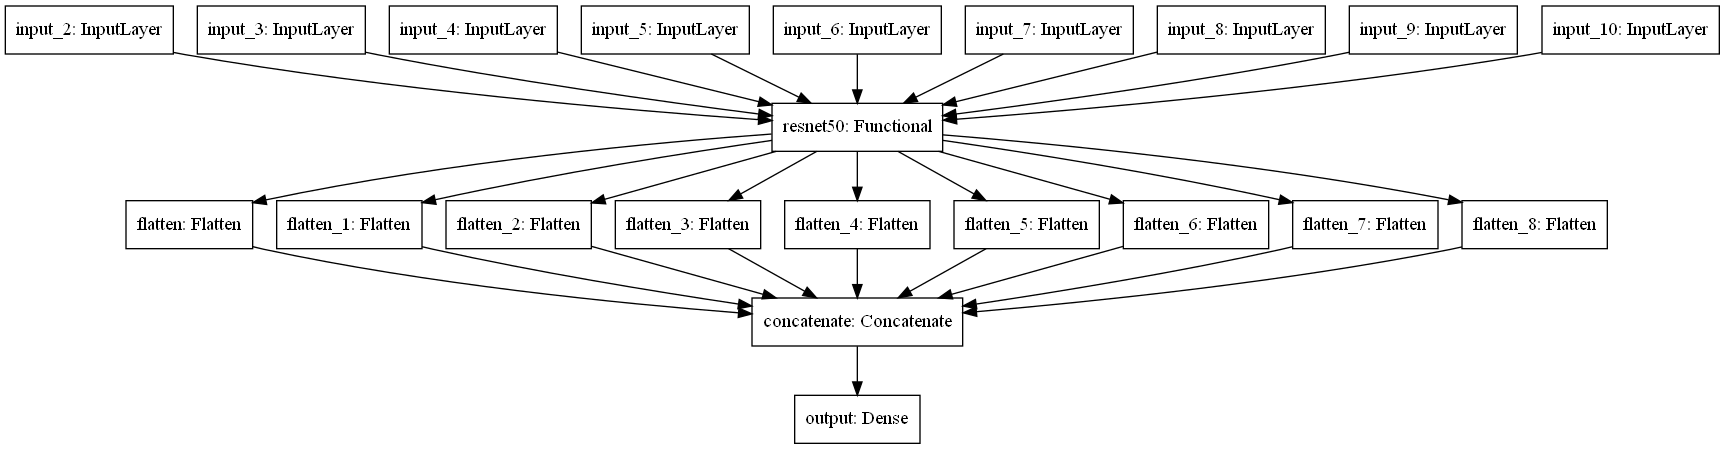

In [14]:
plot_model(model)

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 128, 128, 3) 0                                            
______________________________________________________________________________________________

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(),loss=keras.losses.CategoricalCrossentropy(), metrics=["acc"])

model.fit([X_train[i] for i in range(num_features)], y_train, batch_size=batch_size,
                    epochs=epochs, validation_data=([X_test[i] for i in range(num_features)], y_test))

Epoch 1/10
7099/7352 [===========================>..] - ETA: 10:00 - loss: 5.0884 - acc: 0.5281

# Load model and make predictions

In [16]:
model = keras.models.load_model("resnet50_first.h5")

In [17]:
model.evaluate([X_test[i] for i in range(num_features)], y_test, batch_size=10)

295/295 [==============================] - 563s 2s/step - loss: 1.9660 - acc: 0.8347


[1.9660438299179077, 0.8347471952438354]

In [19]:
predictions = model.predict([X_test[i] for i in range(num_features)])

In [21]:
y_pred = np.argmax(predictions, axis=1)
y_pred

array([5, 5, 5, ..., 2, 2, 2], dtype=int64)

## Plot Confusion Matrix

In [23]:
cm = confusion_matrix(y_true = np.argmax(y_test, axis=1), y_pred = y_pred)
cm

array([[424,   0,   1,   0,  70,   1],
       [ 74, 315,  49,   6,  26,   1],
       [ 55,   2, 363,   0,   0,   0],
       [  0,   0,   0, 486,   5,   0],
       [  0,   0,   2, 195, 335,   0],
       [  0,   0,   0,   0,   0, 537]], dtype=int64)

[Text(0, 0.5, 'WALKING'),
 Text(0, 1.5, 'WALKING\nUPSTAIRS'),
 Text(0, 2.5, 'WALKING\nDOWNSTAIRS'),
 Text(0, 3.5, 'SITTING'),
 Text(0, 4.5, 'STANDING'),
 Text(0, 5.5, 'LAYING')]

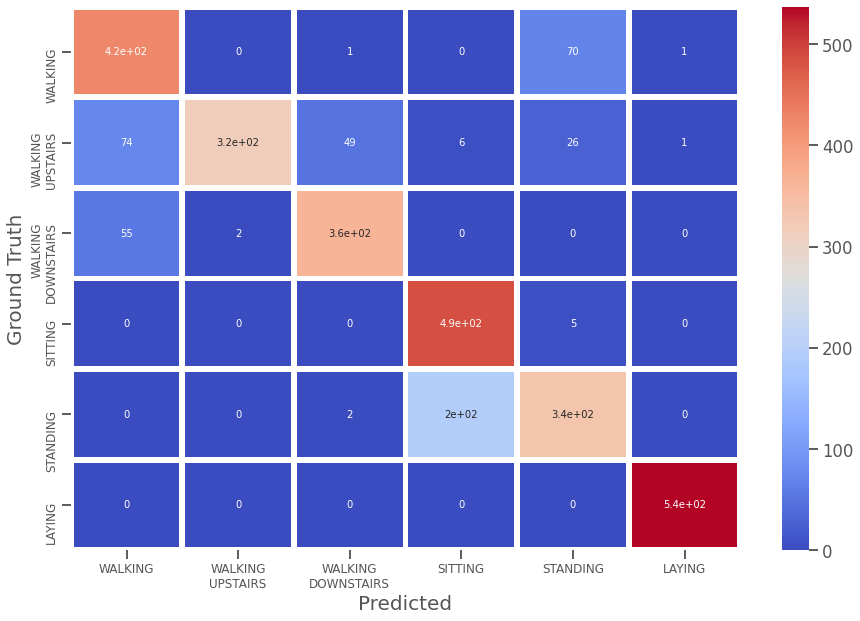

In [42]:
classes = ["WALKING", "WALKING\nUPSTAIRS", "WALKING\nDOWNSTAIRS", "SITTING", "STANDING", "LAYING"]

fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(cm, annot=True, ax=ax, square=False, linewidths=5, cmap="coolwarm")
ax.set_xlabel("Predicted", size=20)
ax.set_ylabel("Ground Truth", size=20)
ax.set_xticklabels(classes, size=12)
ax.set_yticklabels(classes, size=12)
# fig.savefig("confusionM.svg", bbox_inches="tight")

### Classification report

In [45]:
classes = ["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LAYING"]

print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=classes))

                    precision    recall  f1-score   support

           WALKING       0.77      0.85      0.81       496
  WALKING_UPSTAIRS       0.99      0.67      0.80       471
WALKING_DOWNSTAIRS       0.87      0.86      0.87       420
           SITTING       0.71      0.99      0.83       491
          STANDING       0.77      0.63      0.69       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.83      2947
         macro avg       0.85      0.83      0.83      2947
      weighted avg       0.85      0.83      0.83      2947



In [ ]:
# functions used to preprocess signal data

# def transform_data(signal_data, scales=np.arange(1,129), wavelet="morl"):
#     """transform dataset with signals as rows using wavelet transform"""
#     converted = []
#     for i in range(len(signal_data)):
#         coef, freqs=pywt.cwt(signal_data[i,:],scales, wavelet)
#         coef = coef.astype(np.float32)
#         coef = np.stack((coef,)*3, axis=-1)
#         converted.append(coef)
#     return np.array(converted)

# def prepare_dataset(paths, filename="", scales=np.arange(1,129), wavelet="morl"):
#     """Collect all data into numpy array of 5 dimensions"""
#     full_dataset = []
#     for path in paths:
#         data = np.loadtxt(path)
#         transformed = transform_data(data, scales, wavelet)
#         full_dataset.append(transformed)
#         print(f"Done for file: {path}")
#     full_dataset = np.array(full_dataset)
#     if filename:
#         # export dataset into numpy file
#         np.save(filename, full_dataset)
#     return full_dataset